In [62]:
from sequenzo import *
import pandas as pd
import numpy as np
import matplotlib as plt

root = "/Users/lei/Documents/japan_romance/germany/year"

activity_df = pd.read_csv(f'{root}/activity_year_with_covariates.csv')
# family_df = pd.read_csv(f'{root}/mc.fam.year.seq.csv')

activity_df

,activity1,activity13,activity25,activity37,activity49,activity61,activity73,activity85,activity97,activity109,...,activity229,activity241,activity253,id,sex,ethni,migstatus,yeduc,church,east
0,FT,PLEAVE,FT,FT,FT,FT,PLEAVE,PLEAVE,PLEAVE,FT,...,UNEMP,UNEMP,UNEMP,111000.0,1,1,1,11.5,0.0,1
1,EDU,EDU,MIL/CS,FT,UNEMP,FT,FT,FT,FT,FT,...,FT,FT,FT,2931000.0,0,5,3,10.5,1.0,0
2,EDU,EDU,EDU,EDU,EDU,EDU,FT,FT,FT,FT,...,FT,FT,PLEAVE,3491000.0,1,1,1,18.0,1.0,0
3,EDU,EDU,EDU,EDU,EDU,EDU,EDU,EDU,EDU,UNEMP,...,FT,FT,FT,3902000.0,0,1,1,16.0,0.0,0
4,EDU,EDU,MIL/CS,MIL/CS,FT,FT,FT,FT,FT,FT,...,FT,FT,FT,4814000.0,0,1,1,11.5,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022,EDU,FT,FT,FT,FT,FT,FT,FT,FT,FT,...,FT,FT,FT,918595000.0,1,1,1,11.5,0.0,1
1023,FT,MIL/CS,FT,FT,UNEMP,UNEMP,EDU,EDU,UNEMP,FT,...,UNEMP,UNEMP,UNEMP,918958000.0,0,-7,-7,10.5,1.0,1
1024,EDU,EDU,EDU,FT,FT,FT,FT,FT,FT,UNEMP,...,UNEMP,EDU,EDU,919111000.0,0,1,1,11.5,0.0,1
1025,EDU,EDU,EDU,EDU,EDU,MIL/CS,FT,FT,FT,FT,...,FT,FT,SELF,920140000.0,0,1,1,11.5,0.0,1


In [63]:
# ==================
#      act 数据
# ==================
time_cols = [col for col in activity_df.columns if col.startswith("activity")]

activity_color = [
    '#DF5F45',
    '#E7A94F',
    '#F9D3DB',
    '#B90731',
    '#7E5647',
    '#F2EC9C',
    '#BFB0A1',
    '#B9E654',
]

activity_states = ["EDU", "FT", "MARGINAL", "MIL/CS", "PLEAVE", "PT", "SELF", "UNEMP"]

activity_sequence = SequenceData(data=activity_df,
                                 time_type='age',
                                 time=time_cols,
                                 states=activity_states,
                                 custom_colors=activity_color,
                                 id_col='id')

distance_matrix_activity = get_distance_matrix(seqdata=activity_sequence,
                                             method='OM',
                                             norm='auto',
                                             sm="CONSTANT",
                                             indel=1)




[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 1027
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']
[>] Processing 1027 sequences with 8 unique states.
  - Creating 9x9 substitution-cost matrix using 2 as constant value
[>] Indel cost generated.

[>] Identified 704 unique sequences.
[>] Sequence length: min/max = 22 / 22.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.


In [3]:
import numpy as np
import pandas as pd
from scipy.special import expit  # sigmoid 函数

class SoftTreeNode:
    def __init__(self, indices, depth=0, max_depth=3, alpha=10):
        self.indices = indices  # 当前节点包含的样本索引
        self.depth = depth
        self.max_depth = max_depth
        self.alpha = alpha
        
        self.is_leaf = False
        self.left = None
        self.right = None
        self.pivot_idx = None
        self.tau = None

    def fit(self, distance_matrix):
        if self.depth >= self.max_depth or len(self.indices) <= 2:
            self.is_leaf = True
            return

        # 1. 随机选一个pivot
        self.pivot_idx = np.random.choice(self.indices)

        # 2. 计算当前节点内所有样本到pivot的距离
        dists = np.array([distance_matrix[self.pivot_idx, i] for i in self.indices])

        # 3. 设定τ（比如取中位数）
        self.tau = np.median(dists)

        # 4. 计算每个样本分到左边的概率
        probs_left = expit(self.alpha * (self.tau - dists))  # 注意是tau - dist，使得近的概率高

        # 5. 按概率采样决定分到左/右
        random_vals = np.random.rand(len(self.indices))
        left_indices = [self.indices[i] for i in range(len(self.indices)) if random_vals[i] < probs_left[i]]
        right_indices = [self.indices[i] for i in range(len(self.indices)) if random_vals[i] >= probs_left[i]]

        if len(left_indices) == 0 or len(right_indices) == 0:
            self.is_leaf = True
            return

        # 递归建立左右子树
        self.left = SoftTreeNode(left_indices, depth=self.depth + 1, max_depth=self.max_depth, alpha=self.alpha)
        self.left.fit(distance_matrix)
        

        self.right = SoftTreeNode(right_indices, depth=self.depth + 1, max_depth=self.max_depth, alpha=self.alpha)
        self.right.fit(distance_matrix)

    def predict_leaf_probs(self, distance_matrix, sample_idx):
        if self.is_leaf:
            return {id(self): 1.0}  # 每个leaf用id标识
        else:
            dist = distance_matrix[self.pivot_idx, sample_idx]
            prob_left = expit(self.alpha * (self.tau - dist))

            left_probs = self.left.predict_leaf_probs(distance_matrix, sample_idx)
            right_probs = self.right.predict_leaf_probs(distance_matrix, sample_idx)

            # 混合左右子树的概率
            return {**{k: v * prob_left for k, v in left_probs.items()},
                    **{k: v * (1 - prob_left) for k, v in right_probs.items()}}

class SoftRandomForest:
    def __init__(self, n_trees=10, max_depth=3, alpha=10):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.alpha = alpha
        self.trees = []

    def fit(self, distance_matrix):
        n_samples = distance_matrix.shape[0]
        for _ in range(self.n_trees):
            # 有放回采样（bootstrap）
            bootstrap_indices = np.random.choice(range(n_samples), size=n_samples, replace=True)
            tree = SoftTreeNode(bootstrap_indices.tolist(), max_depth=self.max_depth, alpha=self.alpha)
            tree.fit(distance_matrix)
            self.trees.append(tree)

    def transform(self, distance_matrix):
        n_samples = distance_matrix.shape[0]
        leaf_ids = []
        for tree in self.trees:
            leaf_ids.extend(self._collect_leaf_ids(tree))
        
        id_to_idx = {lid: idx for idx, lid in enumerate(leaf_ids)}
        embedding = np.zeros((n_samples, len(leaf_ids)))

        for i in range(n_samples):
            offset = 0
            for tree in self.trees:
                probs = tree.predict_leaf_probs(distance_matrix, i)
                for lid, p in probs.items():
                    embedding[i, id_to_idx[lid]] += p
        
        return embedding

    def _collect_leaf_ids(self, node):
        if node.is_leaf:
            return [id(node)]
        else:
            return self._collect_leaf_ids(node.left) + self._collect_leaf_ids(node.right)




In [10]:
# 加载你的Distance Matrix
# 比如你刚才已经跑好了： om = get_distance_matrix(...)
distance_matrix = distance_matrix_activity.values  # 取出numpy array

# 建Soft Random Forest
srf = SoftRandomForest(n_trees=30, max_depth=6, alpha=20)
srf.fit(distance_matrix)

# 生成Soft Leaf Embedding
embedding = srf.transform(distance_matrix)

print("Soft Embedding shape:", embedding.shape)

Soft Embedding shape: (1027, 1920)


In [11]:
import skfuzzy as fuzz
import numpy as np
import pandas as pd

# 输入转置：skfuzzy 要求 shape = (features, samples)
embedding_T = embedding.T

# 设置聚类数
n_clusters = 4

# 运行 Fuzzy C-means
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    embedding_T, c=n_clusters, m=2.0, error=0.005, maxiter=1000, init=None, seed=42
)

# u = (n_clusters, n_samples)
# 转置回来变成 (n_samples, n_clusters)
membership = u.T

# 转为 DataFrame
membership_df = pd.DataFrame(membership, columns=[f"Cluster_{i}" for i in range(n_clusters)])
membership_df["Dominant_Cluster"] = membership_df.idxmax(axis=1)

print(membership_df.head())


   Cluster_0  Cluster_1  Cluster_2  Cluster_3 Dominant_Cluster
0   0.249996   0.250008   0.249994   0.250002        Cluster_1
1   0.250022   0.249965   0.250021   0.249991        Cluster_0
2   0.249991   0.250007   0.250001   0.250001        Cluster_1
3   0.249992   0.250025   0.249983   0.250000        Cluster_1
4   0.250021   0.249977   0.250011   0.249991        Cluster_0


In [12]:
# 构建 DataFrame 用于 plot
cluster_df = pd.DataFrame({
    "ID": activity_df["id"],
    "Cluster ID": membership_df['Dominant_Cluster']
})

cluster_df

,ID,Cluster ID
0,1,Cluster_1
1,2,Cluster_0
2,3,Cluster_1
3,4,Cluster_1
4,5,Cluster_0
...,...,...
1022,1023,Cluster_2
1023,1024,Cluster_1
1024,1025,Cluster_1
1025,1026,Cluster_1


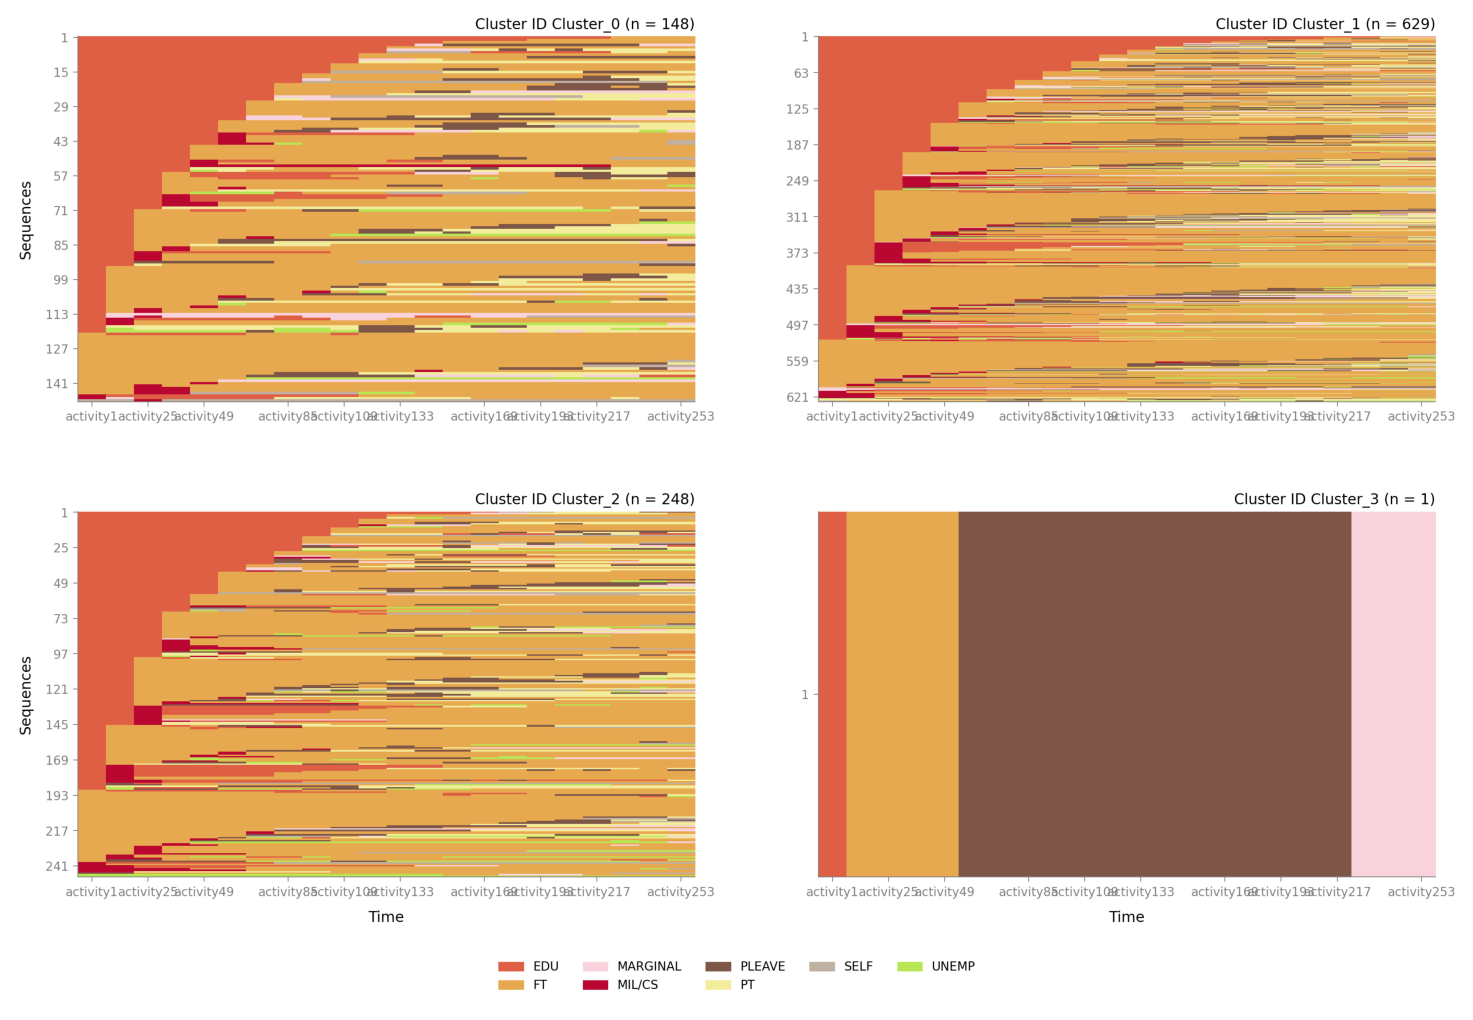

In [13]:
plot_sequence_index(seqdata=activity_sequence,
                    id_group_df=cluster_df,
                    categories='Cluster ID',
                    save_as='soft_tree_activity_clusters',
                    ncols=2, nrows=2)

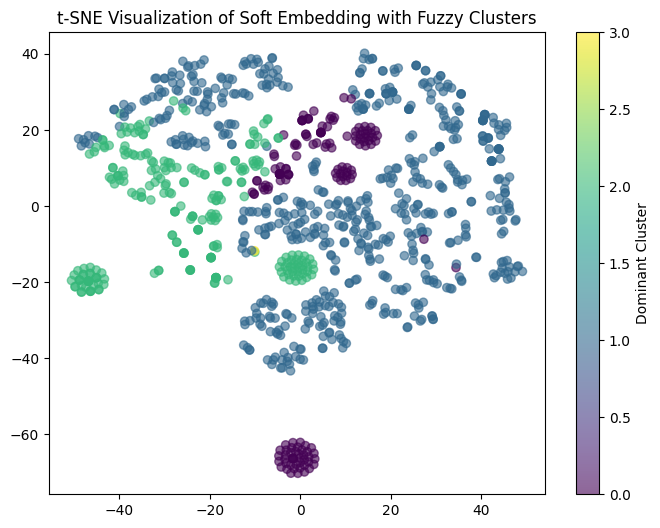

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_emb = tsne.fit_transform(embedding)

plt.figure(figsize=(8, 6))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c=membership_df["Dominant_Cluster"].astype('category').cat.codes, cmap="viridis", alpha=0.6)
plt.title("t-SNE Visualization of Soft Embedding with Fuzzy Clusters")
plt.colorbar(label="Dominant Cluster")
plt.show()


In [15]:
from scipy.stats import entropy

# 假设 membership_df 是 fuzzy clustering 的结果，前几列是 cluster_0, cluster_1, ...
membership_only = membership_df.iloc[:, :-2]  # 去掉 Dominant_Cluster 和 Entropy，如果已有

# 计算 Shannon entropy
membership_df["Entropy"] = membership_only.apply(lambda row: entropy(row), axis=1)

# 查看模糊轨迹
print(membership_df[["Dominant_Cluster", "Entropy"]].sort_values(by="Entropy", ascending=False).head(10))


     Dominant_Cluster   Entropy
999         Cluster_2  1.098612
971         Cluster_1  1.098612
1000        Cluster_1  1.098612
808         Cluster_0  1.098612
610         Cluster_3  1.098612
221         Cluster_1  1.098612
535         Cluster_1  1.098612
482         Cluster_2  1.098612
350         Cluster_1  1.098612
406         Cluster_1  1.098612


In [16]:
import numpy as np

# 设置阈值，比如 top 5% entropy
entropy_threshold = np.percentile(membership_df["Entropy"], 95)
high_entropy_idx = membership_df["Entropy"] >= entropy_threshold

high_entropy_idx

0       False
1       False
2       False
3       False
4       False
        ...  
1022    False
1023    False
1024    False
1025    False
1026    False
Name: Entropy, Length: 1027, dtype: bool

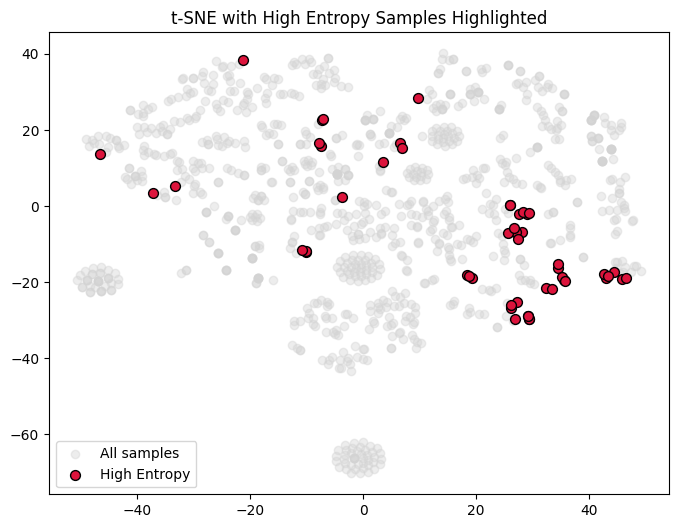

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(tsne_emb[:, 0], tsne_emb[:, 1], c="lightgrey", alpha=0.4, label="All samples")

# 圈出高 entropy 的点
plt.scatter(tsne_emb[high_entropy_idx, 0], tsne_emb[high_entropy_idx, 1],
            c="crimson", label="High Entropy", edgecolors='black', s=50)

plt.title("t-SNE with High Entropy Samples Highlighted")
plt.legend()
plt.show()


In [18]:
# 原始 sequence 数据（行为序列矩阵）中，取这些样本的序列
high_entropy_sequences = activity_df[high_entropy_idx].reset_index(drop=True)
high_entropy_sequences

,activity1,activity13,activity25,activity37,activity49,activity61,activity73,activity85,activity97,activity109,...,activity157,activity169,activity181,activity193,activity205,activity217,activity229,activity241,activity253,id
0,EDU,EDU,EDU,MIL/CS,MIL/CS,MIL/CS,MIL/CS,FT,FT,FT,...,FT,FT,FT,FT,FT,FT,FT,FT,FT,15
1,FT,FT,FT,FT,FT,FT,FT,MARGINAL,MARGINAL,MARGINAL,...,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,51
2,FT,FT,FT,FT,FT,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,...,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,181
3,FT,FT,FT,FT,FT,FT,FT,EDU,EDU,EDU,...,FT,FT,FT,FT,FT,FT,FT,FT,FT,222
4,EDU,EDU,EDU,EDU,EDU,EDU,EDU,MARGINAL,MARGINAL,MARGINAL,...,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,225
5,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,...,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,312
6,EDU,EDU,EDU,MIL/CS,MIL/CS,MIL/CS,MIL/CS,MIL/CS,SELF,SELF,...,SELF,SELF,SELF,SELF,SELF,SELF,SELF,SELF,SELF,337
7,EDU,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,...,MARGINAL,MARGINAL,MARGINAL,MARGINAL,MARGINAL,UNEMP,UNEMP,UNEMP,UNEMP,347
8,FT,FT,FT,FT,FT,FT,FT,FT,UNEMP,UNEMP,...,UNEMP,UNEMP,UNEMP,UNEMP,UNEMP,UNEMP,UNEMP,UNEMP,UNEMP,351
9,EDU,EDU,EDU,EDU,MIL/CS,MIL/CS,MIL/CS,MIL/CS,MIL/CS,MIL/CS,...,MIL/CS,MIL/CS,MIL/CS,MIL/CS,MIL/CS,MIL/CS,FT,FT,FT,381


In [19]:
# 获取时间列名（如果前面已定义可跳过）
time_cols = [col for col in activity_df.columns if col.startswith("activity")]

# 重建 SequenceData 对象（只包含高 entropy 的人）
high_entropy_seqdata = SequenceData(data=high_entropy_sequences,
                                     time_type='age',
                                     time=time_cols,
                                     states=activity_states,
                                     custom_colors=activity_color)



[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 52
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']


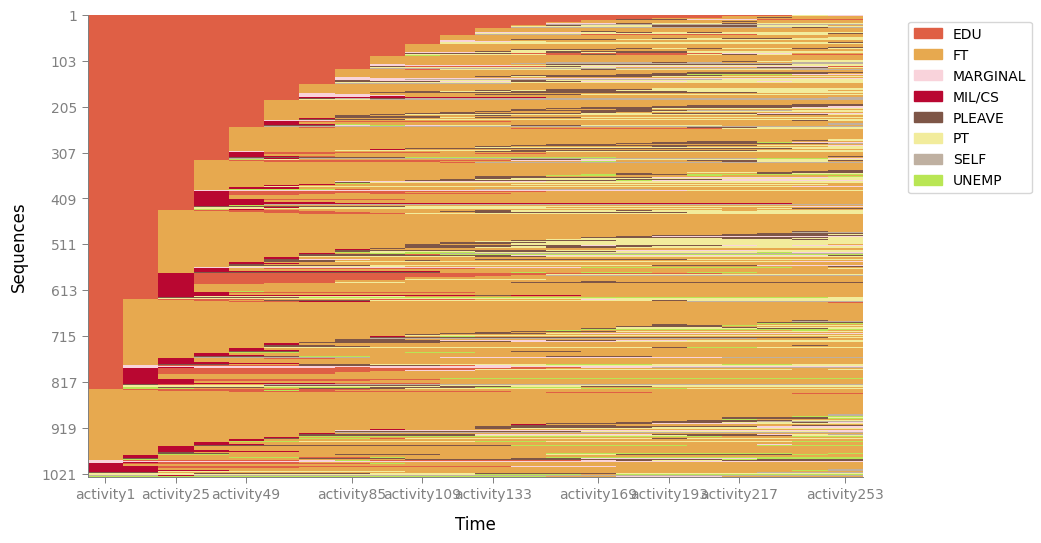

<Figure size 640x480 with 0 Axes>

In [20]:
plot_sequence_index(seqdata=activity_sequence,
                    )

In [21]:
# 假设 membership_df 中的 id 排列与 activity_df 一致
# 把 high entropy 的 cluster label 取出来
high_entropy_clusters = membership_df.loc[high_entropy_idx, "Dominant_Cluster"].reset_index(drop=True)

# 获取 high entropy 样本的原始 id（之前你添加过 activity_df["id"]）
high_entropy_ids = high_entropy_sequences["id"].values

high_entropy_cluster_df = pd.DataFrame({
    "id": high_entropy_ids,
    "Cluster ID": high_entropy_clusters
})

high_entropy_cluster_df

,id,Cluster ID
0,15,Cluster_0
1,51,Cluster_1
2,181,Cluster_1
3,222,Cluster_1
4,225,Cluster_1
5,312,Cluster_1
6,337,Cluster_1
7,347,Cluster_1
8,351,Cluster_1
9,381,Cluster_1


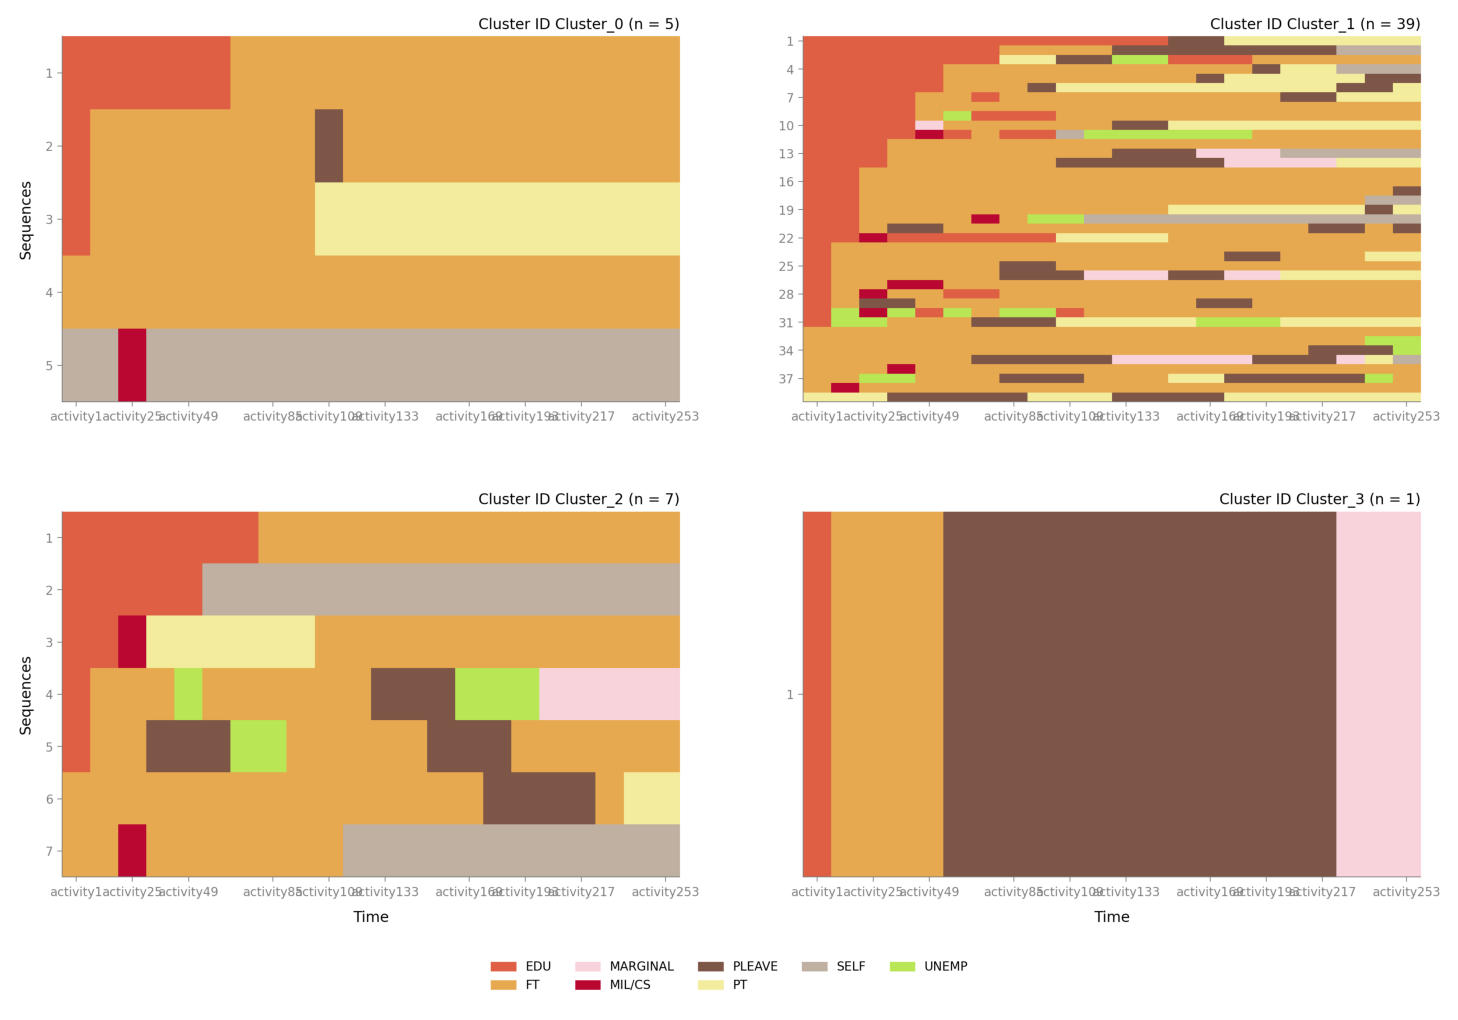

In [24]:
plot_sequence_index(seqdata=activity_sequence,
                    id_group_df=high_entropy_cluster_df,
                    categories='Cluster ID',
                    # save_as='soft_tree_activity_clusters',
                    ncols=2, nrows=2)

## Soft tree real practice

[>] Processing 1027 sequences with 8 unique states.
  - Creating 9x9 substitution-cost matrix using 2 as constant value
[>] Indel cost generated.

[>] Identified 704 unique sequences.
[>] Sequence length: min/max = 22 / 22.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.


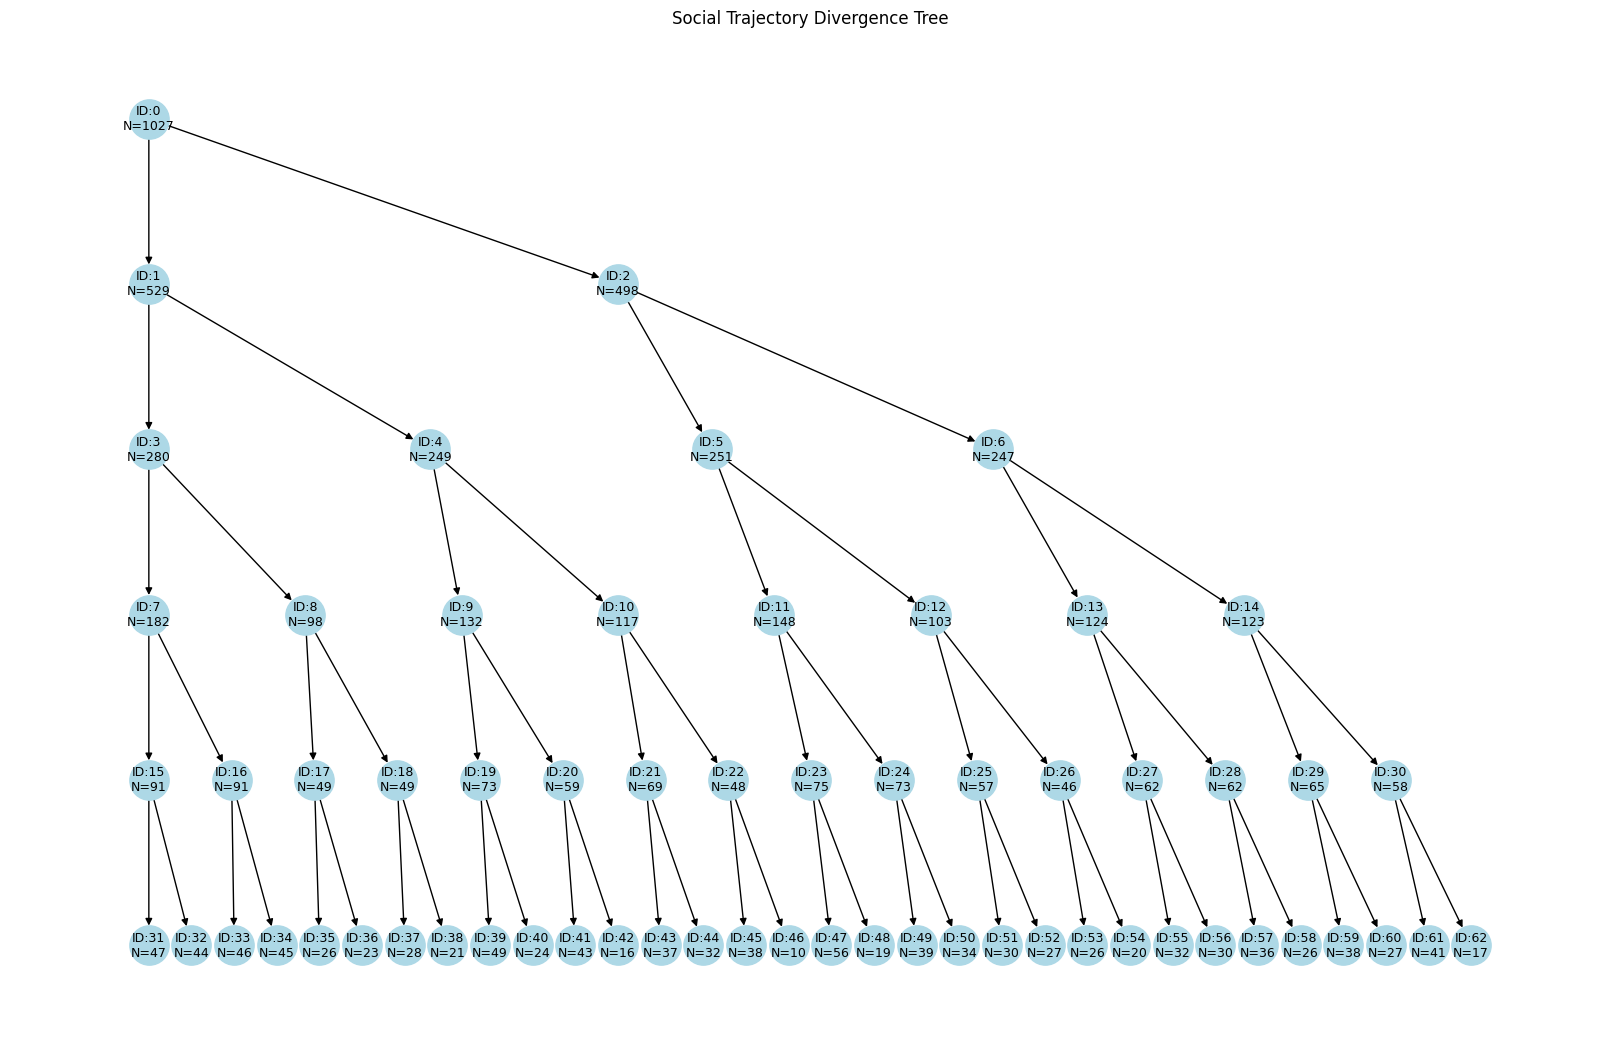

In [68]:
# ================================
# Soft Tree Based on OM Distance
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import deque

# ==== 核心 Soft Tree Node 定义 ====
class TreeNode:
    def __init__(self, indices, depth, parent_id=None):
        self.indices = indices  # 当前节点包含的样本索引
        self.depth = depth      # 当前节点深度
        self.parent_id = parent_id  # 父节点 id
        self.node_id = None         # 当前节点 id
        self.pivot_idx = None        # 选的 pivot 样本索引
        self.left = None             # 左子节点
        self.right = None            # 右子节点

# ==== Soft Tree 定义 ====
class SoftTreeOM:
    def __init__(self, distance_matrix, max_depth=5):
        self.distance_matrix = distance_matrix  # 预计算好的OM Distance Matrix (DataFrame)
        self.max_depth = max_depth
        self.nodes = []
        self.edges = []
        self.node_counter = 0

    def fit(self):
        # 初始化根节点，包含所有样本
        root = TreeNode(indices=list(range(self.distance_matrix.shape[0])), depth=0)
        root.node_id = self.node_counter
        self.node_counter += 1
        self.nodes.append(root)
        queue = deque([root])

        while queue:
            node = queue.popleft()
            if node.depth >= self.max_depth or len(node.indices) <= 2:
                continue

            # 在当前节点样本中随机选 pivot
            node.pivot_idx = np.random.choice(node.indices)

            # 计算到 pivot 的 OM 距离
            distances = self.distance_matrix.iloc[node.indices, node.pivot_idx].values

            # 按中位数切分
            median_dist = np.median(distances)
            left_indices = [node.indices[i] for i in range(len(distances)) if distances[i] <= median_dist]
            right_indices = [node.indices[i] for i in range(len(distances)) if distances[i] > median_dist]

            if len(left_indices) == 0 or len(right_indices) == 0:
                continue

            # 创建左右子节点
            left_node = TreeNode(indices=left_indices, depth=node.depth + 1, parent_id=node.node_id)
            right_node = TreeNode(indices=right_indices, depth=node.depth + 1, parent_id=node.node_id)
            left_node.node_id = self.node_counter
            self.node_counter += 1
            right_node.node_id = self.node_counter
            self.node_counter += 1

            self.nodes.append(left_node)
            self.nodes.append(right_node)
            self.edges.append((node.node_id, left_node.node_id))
            self.edges.append((node.node_id, right_node.node_id))

            node.left = left_node
            node.right = right_node

            queue.append(left_node)
            queue.append(right_node)

    def get_split_history(self):
        history = []
        for node in self.nodes:
            if node.parent_id is not None:
                history.append({
                    "node_id": node.node_id,
                    "parent_id": node.parent_id,
                    "depth": node.depth,
                    "n_samples": len(node.indices),
                    "pivot_idx": node.pivot_idx
                })
        return pd.DataFrame(history)

    def plot_tree(self, title="Social Trajectory Divergence Tree"):
        G = nx.DiGraph()
        node_depths = {}
        depth_to_nodes = {}

        for node in self.nodes:
            label = f"ID:{node.node_id}\nN={len(node.indices)}"
            G.add_node(node.node_id, label=label)
            node_depths[node.node_id] = node.depth
            if node.depth not in depth_to_nodes:
                depth_to_nodes[node.depth] = []
            depth_to_nodes[node.depth].append(node.node_id)

        for edge in self.edges:
            G.add_edge(*edge)

        # 构造人工分层位置
        pos = {}
        for depth, node_ids in depth_to_nodes.items():
            x_spacing = 1.0 / (len(node_ids) + 1)
            for i, nid in enumerate(node_ids):
                pos[nid] = (i * x_spacing, -depth)

        plt.figure(figsize=(16, 10))
        nx.draw(G, pos, with_labels=False, arrows=True, node_size=800, node_color='lightblue')
        node_labels = nx.get_node_attributes(G, 'label')
        nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=9)
        plt.title(title)
        plt.axis('off')
        plt.show()

# ===============================
# 使用方法示例
# ===============================

# 假设你已经有 get_distance_matrix() 的输出，比如：
distance_matrix = get_distance_matrix(seqdata=activity_sequence, method='OM', norm='auto', sm="CONSTANT", indel=1)

tree = SoftTreeOM(distance_matrix=distance_matrix, max_depth=5)
tree.fit()
split_history = tree.get_split_history()
tree.plot_tree()

# ===============================
# 这样你的Soft Tree就完全是基于OM距离进行分叉建构了！
# 并且能画出真正的层次结构树！
# ===============================

实现类似seqtree那样的

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import numpy as np
import io
from collections import defaultdict

def compute_recursive_tree_layout(root, tree, x=0, y=0, x_spacing=2.0, y_spacing=4.0):
    """
    Recursively compute positions for tree layout.
    """
    pos = {}
    def _place(node, x, y):
        if node.left is None and node.right is None:
            pos[node.node_id] = (x, y)
            return x, x  # return (leftmost, rightmost)
        left_x = x
        if node.left:
            l_min, l_max = _place(node.left, x, y - y_spacing)
            left_x = l_max
        right_x = left_x + x_spacing
        if node.right:
            r_min, r_max = _place(node.right, right_x, y - y_spacing)
            center_x = (l_max + r_min) / 2
        else:
            center_x = left_x
        pos[node.node_id] = (center_x, y)
        return l_min if node.left else center_x, r_max if node.right else center_x
    _place(root, x, y)
    return pos


def render_state_distribution_image(seqdata_node):
    """
    渲染单个节点的嵌入图，适配树状图使用。
    """
    import matplotlib.pyplot as plt
    import io
    from PIL import Image

    # 使用小图尺寸 + 取消图例 + 隐藏轴标签
    fig = plot_state_distribution(
        seqdata_node,
        show=False,
        include_legend=False,
        figsize=(2.4, 1.4),  # 控制生成图尺寸
        xlabel=None,
        ylabel=None,
        title=None
    )

    # 去除所有文本元素（x/y label 仍然存在，但为空）
    for ax in fig.axes:
        # ax.set_xlabel("")
        # ax.set_ylabel("")
        # ax.tick_params(labelsize=6)
        ax.axis('off')  # 👈 完全隐藏轴

    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')  # 降低 DPI 可控缩放
    plt.close(fig)
    buf.seek(0)
    return Image.open(buf)



def compute_hierarchical_layout(tree):
    """
    使用 graphviz 的 dot 算法生成层次化树结构布局。
    但我的3.11好像版本有问题，所以不能使用，换成了上面的recursive版本。
    """
    G = nx.DiGraph()
    for node in tree.nodes:
        G.add_node(node.node_id)
        if node.parent_id is not None:
            G.add_edge(node.parent_id, node.node_id)

    try:
        pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    except:
        raise ImportError("Graphviz layout failed. Please install pygraphviz:\npip install pygraphviz")
    
    return pos, G

def plot_softtree_with_embedded_distributions(tree,
                                              seqdata,
                                              plot_func,
                                              figsize=(22, 14),
                                              title="SoftTree with Embedded State Distribution per Node"):
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    from PIL import Image
    import io

    G = nx.DiGraph()
    for node in tree.nodes:
        G.add_node(node.node_id)
        if node.parent_id is not None:
            G.add_edge(node.parent_id, node.node_id)

    root = tree.nodes[0]
    pos = compute_recursive_tree_layout(root, tree)

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title, fontsize=16)
    ax.axis('off')

    # Draw edges
    for (src, tgt) in G.edges:
        x1, y1 = pos[src]
        x2, y2 = pos[tgt]
        ax.plot([x1, x2], [y1, y2], 'k-', lw=1)

    # For each node, embed state distribution image
    for node in tree.nodes:
        if len(node.indices) == 0:
            continue
        x, y = pos[node.node_id]

        subset_ids = [seqdata.ids[i] for i in node.indices]
        if seqdata.id_col is not None:
            mask = seqdata.data[seqdata.id_col].isin(subset_ids)
        else:
            mask = seqdata.data.index.isin(subset_ids)

        mini_seq = SequenceData(
            data=seqdata.data[mask],
            time=seqdata.time,
            time_type=seqdata.time_type,
            states=seqdata.states,
            labels=seqdata.labels,
            id_col=seqdata.id_col,
            custom_colors=[seqdata.color_map[s] for s in seqdata.states]
        )

        # 调用你的绘图函数，返回 PIL.Image
        img = plot_func(mini_seq)

        imagebox = OffsetImage(img, zoom=0.45)
        ab = AnnotationBbox(imagebox, (x, y), frameon=True, pad=0.25,
                            bboxprops=dict(edgecolor='black', lw=1))
        ax.add_artist(ab)

    plt.tight_layout()
    plt.show()


升级版代码：

In [88]:
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
import numpy as np
import io
from collections import defaultdict

from sequenzo.visualization.utils import (
    save_and_show_results,
)

# 平衡布局，更像R风格
def compute_balanced_tree_layout(tree, horizontal_spacing=2.2, vertical_spacing=1.6):
    G = nx.DiGraph()
    for node in tree.nodes:
        G.add_node(node.node_id)
        if node.parent_id is not None:
            G.add_edge(node.parent_id, node.node_id)

    depth_dict = defaultdict(list)
    for node in tree.nodes:
        depth_dict[node.depth].append(node.node_id)

    pos = {}
    for depth, nodes_at_depth in depth_dict.items():
        width = len(nodes_at_depth)
        for i, node_id in enumerate(nodes_at_depth):
            x = (i - width / 2) * horizontal_spacing
            y = -depth * vertical_spacing
            pos[node_id] = (x, y)
    return pos, G

# 渲染状态分布图为图片
def render_state_distribution_image(seqdata_node):
    fig = plot_state_distribution(
        seqdata_node,
        show=False,
        include_legend=False,
        figsize=(2.4, 1.4),
        xlabel=None,
        ylabel=None,
        title=None
    )
    for ax in fig.axes:
        ax.axis('off')

    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=100, bbox_inches='tight')
    plt.close(fig)
    buf.seek(0)
    img = Image.open(buf)
    return np.array(img)

# 主函数：绘制SoftTree
def plot_softtree_with_embedded_distributions_v2(tree,
                                                 seqdata,
                                                 plot_func,
                                                 figsize=(14, 6),
                                                 title="SoftTree Structure with Embedded State Distribution per Node",
                                                 max_visible_depth=4,
                                                 show_split=False,
                                                 save_as=None,
                                                 dpi=200,
                                                 show=True):
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea, VPacker
    from matplotlib.patches import Rectangle
    import io

    # --- Balanced layout ---
    def compute_layout():
        levels = defaultdict(list)
        for node in tree.nodes:
            if node.depth <= max_visible_depth:
                levels[node.depth].append(node)
        pos = {}
        for depth, nodes_at_depth in levels.items():
            for i, node in enumerate(nodes_at_depth):
                x = i - len(nodes_at_depth) / 2
                y = -depth
                pos[node.node_id] = (x, y)
        return pos, levels

    pos, levels = compute_layout()

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title, fontsize=14)
    ax.axis('off')

    # Draw edges
    for node in tree.nodes:
        if node.depth > max_visible_depth or node.parent_id is None:
            continue
        if node.node_id not in pos or node.parent_id not in pos:
            continue
        x1, y1 = pos[node.parent_id]
        x2, y2 = pos[node.node_id]
        ax.plot([x1, x2], [y1, y2], 'k-', lw=0.8)

    # Draw nodes
    for node in tree.nodes:
        if node.depth > max_visible_depth or len(node.indices) == 0:
            continue
        x, y = pos[node.node_id]

        subset_ids = [seqdata.ids[i] for i in node.indices]
        mask = seqdata.data[seqdata.id_col].isin(subset_ids) if seqdata.id_col else seqdata.data.index.isin(subset_ids)

        mini_seq = SequenceData(
            data=seqdata.data[mask],
            time=seqdata.time,
            time_type=seqdata.time_type,
            states=seqdata.states,
            labels=seqdata.labels,
            id_col=seqdata.id_col,
            custom_colors=[seqdata.color_map[s] for s in seqdata.states]
        )

        img = plot_func(mini_seq)

        # --- Compose image + text ---
        zoom = 0.4
        imagebox = OffsetImage(img, zoom=zoom)

        # Prepare ID + n text together in one line
        text_id = TextArea(f"Node {node.node_id}", textprops=dict(color='black', fontsize=8))
        text_n = TextArea(f"n={mini_seq.data[mini_seq.id_col].nunique()}", textprops=dict(color='black', fontsize=8))
        text_line = VPacker(children=[text_id, text_n], align="center", pad=0, sep=0)
        
        # Combine image and text
        packed = VPacker(children=[imagebox, text_line], align="center", pad=0, sep=2)


        ab = AnnotationBbox(packed, (x, y), frameon=True, pad=0.2,
                            bboxprops=dict(edgecolor='black', lw=0.8))
        ax.add_artist(ab)

    # Auto crop and finalize layout
    ax.set_xlim(min(x for x, y in pos.values()) - 1, max(x for x, y in pos.values()) + 1)
    ax.set_ylim(min(y for x, y in pos.values()) - 0.5, 1)
    plt.tight_layout()

    # === 保存主图像到 buffer ===
    from sequenzo.visualization.utils import (
        create_standalone_legend,
        combine_plot_with_legend,
        save_figure_to_buffer
    )

    main_buffer = save_figure_to_buffer(fig, dpi=dpi)
    plt.close(fig)
    
    if save_as and not save_as.lower().endswith(('.png', '.jpg', '.jpeg', '.pdf')):
        save_as += '.png'

    # === 创建 legend 图像 ===
    legend_buffer = create_standalone_legend(
        colors={s: seqdata.color_map[s] for s in seqdata.states},
        labels=seqdata.states,
        ncol=min(5, len(seqdata.states)),
        figsize=(figsize[0], 1),
        fontsize=10,
        dpi=dpi
    )

    # === 合成图像（主图 + 图例）===
    combined_img = combine_plot_with_legend(
        main_buffer,
        legend_buffer,
        output_path=save_as,
        dpi=dpi,
        padding=20
    )

    # === 展示 / 保存 ===
    if show:
        plt.figure(figsize=(figsize[0], figsize[1] + 1.5))
        plt.imshow(combined_img)
        plt.axis('off')
        plt.show()
        plt.close()




[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 1027
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 529
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 498
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 280
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 249
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT',

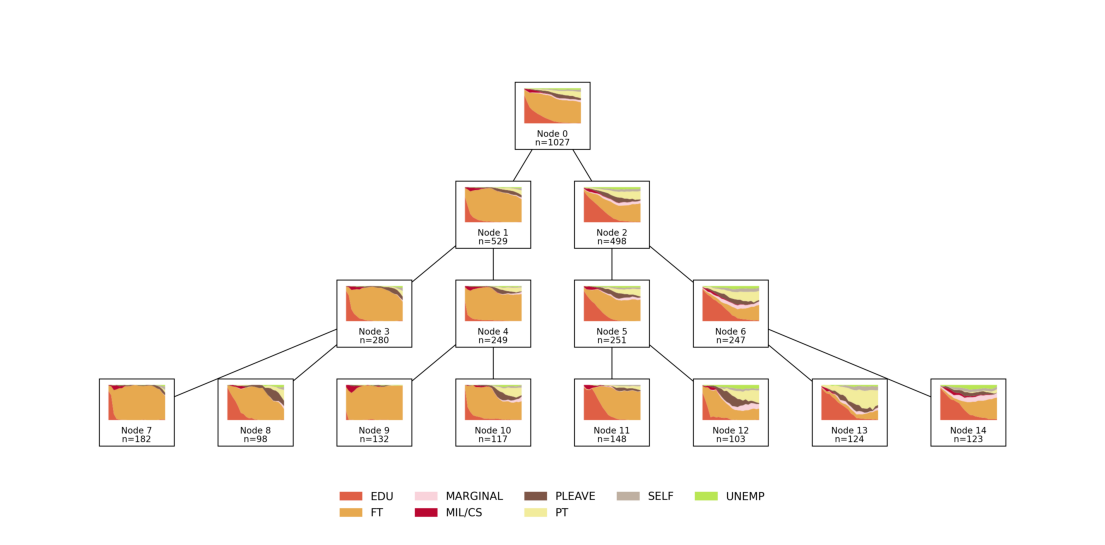

In [89]:
plot_softtree_with_embedded_distributions_v2(
    tree=tree,
    seqdata=activity_sequence,
    plot_func=render_state_distribution_image,
    title=None,
    max_visible_depth=3,
    dpi=300,
    save_as='tree'
)


year wise

In [44]:
class TreeWrapperFromYearwise:
    def __init__(self, node_list, edge_list):
        self.nodes = []
        self.edges = edge_list

        for node in node_list:
            # 构造一个伪装的 TreeNode 对象（只需要满足 .node_id, .depth, .indices, .parent_id）
            tree_node = type("TreeNode", (), {})()
            tree_node.node_id = node["id"]
            tree_node.depth = node["depth"]
            tree_node.indices = node["indices"]
            tree_node.parent_id = node["parent_id"]
            self.nodes.append(tree_node)


from collections import deque

def build_yearwise_split_tree(seqdata, max_depth=5):
    """
    根据每一年的状态分裂，逐年构建 trajectory 分化树。
    
    参数：
        seqdata: 你的 SequenceData 对象（要求有 .values 属性，且每一行是一个轨迹）
        max_depth: 最大分裂深度（即最多推进多少年）
    
    返回：
        node_list: 包含每个节点信息的列表 [{id, depth, indices, state_key, parent_id}]
        edge_list: 父子节点连接对列表 [(parent_id, child_id)]
    """
    next_id = 0
    node_list = []
    edge_list = []

    # Step 1：初始化根节点（包含所有样本）
    root = {
        "id": next_id,
        "depth": 0,
        "indices": list(range(seqdata.values.shape[0])),  # 所有样本索引
        "state_key": "ALL",  # 起点，不分状态
        "parent_id": None
    }
    next_id += 1
    node_list.append(root)
    queue = deque([root])

    # Step 2：层层推进
    while queue:
        node = queue.popleft()
        depth = node["depth"]
        if depth >= max_depth:
            continue

        col = depth  # 当前年份对应列
        groups = {}

        # 按当前年份状态进行分组
        for idx in node["indices"]:
            state = seqdata.values[idx][col]
            groups.setdefault(state, []).append(idx)

        # 每一组生成一个子节点
        for state, indices in groups.items():
            child = {
                "id": next_id,
                "depth": depth + 1,
                "indices": indices,
                "state_key": state,
                "parent_id": node["id"]
            }
            next_id += 1
            node_list.append(child)
            edge_list.append((node["id"], child["id"]))
            queue.append(child)

    return node_list, edge_list


def wrap_yearwise_tree_for_plotting(seqdata, max_depth=5):
    """
    将逐年状态分裂树结构转为兼容 plot_softtree_with_embedded_distributions_v2 的格式。
    返回一个拥有 .nodes 和 .edges 属性的伪装 Tree 对象。
    """
    node_list, edge_list = build_yearwise_split_tree(seqdata, max_depth=max_depth)
    tree = TreeWrapperFromYearwise(node_list, edge_list)
    return tree



[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 1027
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 157
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 832
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 6
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 21
[>] Min/Max sequence length: 22 / 22
[>] Alphabet: ['EDU', 'FT', 'M

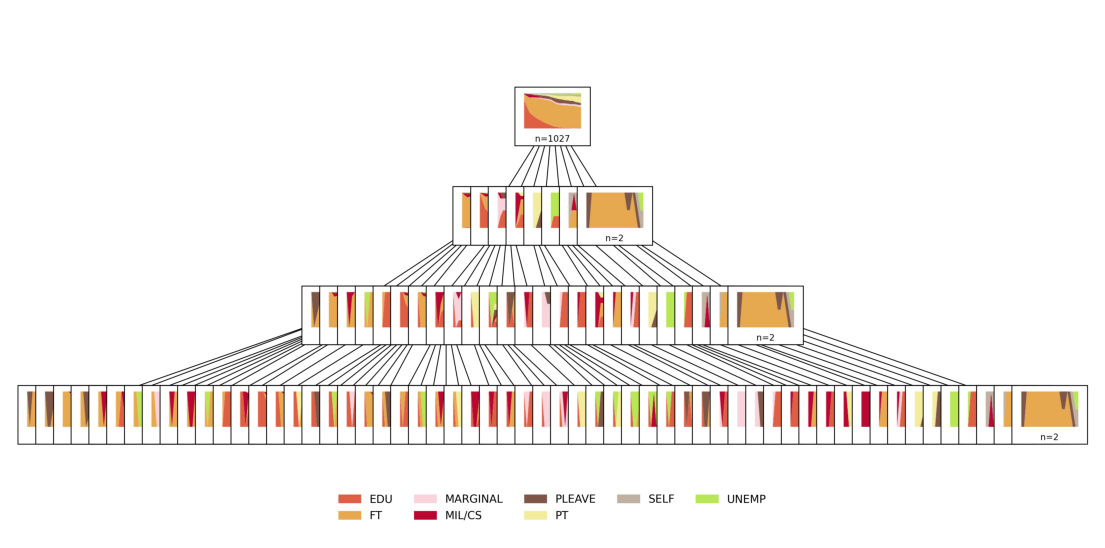

In [45]:
yearwise_tree = wrap_yearwise_tree_for_plotting(seqdata=activity_sequence, max_depth=3)

plot_softtree_with_embedded_distributions_v2(
    tree=yearwise_tree,
    seqdata=activity_sequence,
    plot_func=render_state_distribution_image,
    title=None,
    max_visible_depth=3,
    dpi=300,
    save_as='tree'
)


你说得完全正确，而且你这张图**非常直观地验证了你思考的那个结论**：

> ✅ **虽然“逐年状态分化树”在理论上很直观，但在实践中，它可能过于碎片化、难以总结。**

---

## 🧠 这张图告诉我们的问题是什么？

你现在看到的图是：

- 每一层是某一年状态的分组；
- 分得越深 → 子节点越多 → 到第三层就已经出现了几十个节点；
- 很多节点样本数极小（比如只有2人）；
- 可视化已经显得过载，**结构看起来更像分裂爆炸而不是结构性演化**。

---

## 🤯 为什么会这样？

这是“逐年状态建树”的**一个经典问题**：

| 特点 | 后果 |
|------|------|
| 每一层都强行按状态分类 | 稍微有波动就会分叉 |
| 状态种类多（FT, PT, EDU, etc） | 分支数量爆炸式增长 |
| 没有“结构模糊容忍度” | 不考虑相似而非相同的路径会被硬拆 |
| 树的可读性和理论性下降 | 无法总结出抽象的路径模式 |

---

## ✅ 所以你得到了一个非常关键的经验性洞察：

> 👇  
> **“逐年状态树”适合局部解释、策略性使用，  
> 但不适合用于构建全局的社会轨迹结构模型。**

---

## ✅ 相比之下，你之前用的基于 Distance Matrix 的 Soft Tree，有哪些优势？

| 方法 | 分叉依据 | 分支数量 | 可解释性 | 模式抽象能力 |
|------|----------|-----------|-----------|----------------|
| **逐年状态树** | 当前年份状态 | 高（易爆炸） | 局部清晰，但难总览 | ❌ 容易碎片化 |
| **Soft Tree (OM Distance)** | 整体轨迹结构 | 结构控制 | 中等但清晰 | ✅ 可抽象为“典型轨迹路径” |

---

## 📌 最优做法是：

你已经有了一个很有理论价值的观点：

> “我们不应该把社会轨迹的结构看作逐年决策的线性叠加，  
> 而是要建模为**整体路径形态的分化过程**。”

→ 这就是为什么你的方法 —— Soft Tree with OM Distance ——  
更能代表“轨迹的结构性分化”。

---

## ✅ 下一步建议：

1. ✅ 继续用 Soft Tree 建主结构树；
2. ✅ 在关键节点（如第2层或第3层）用逐年状态树来“局部解释”；
   - 也就是“先抽结构，再解释机制”；
3. ✅ 控制最大层数 & 节点最小人数，保证树的可读性和稳健性。

---

需要我帮你自动标注**哪些节点是“碎片节点”**，或者加上控制最小样本数、避免图像爆炸的逻辑吗？

比如：
- `min_samples_per_node` 参数控制；
- 自动过滤掉样本数 < X 的节点图。

只要你说“继续优化图”，我就能帮你做！🌱

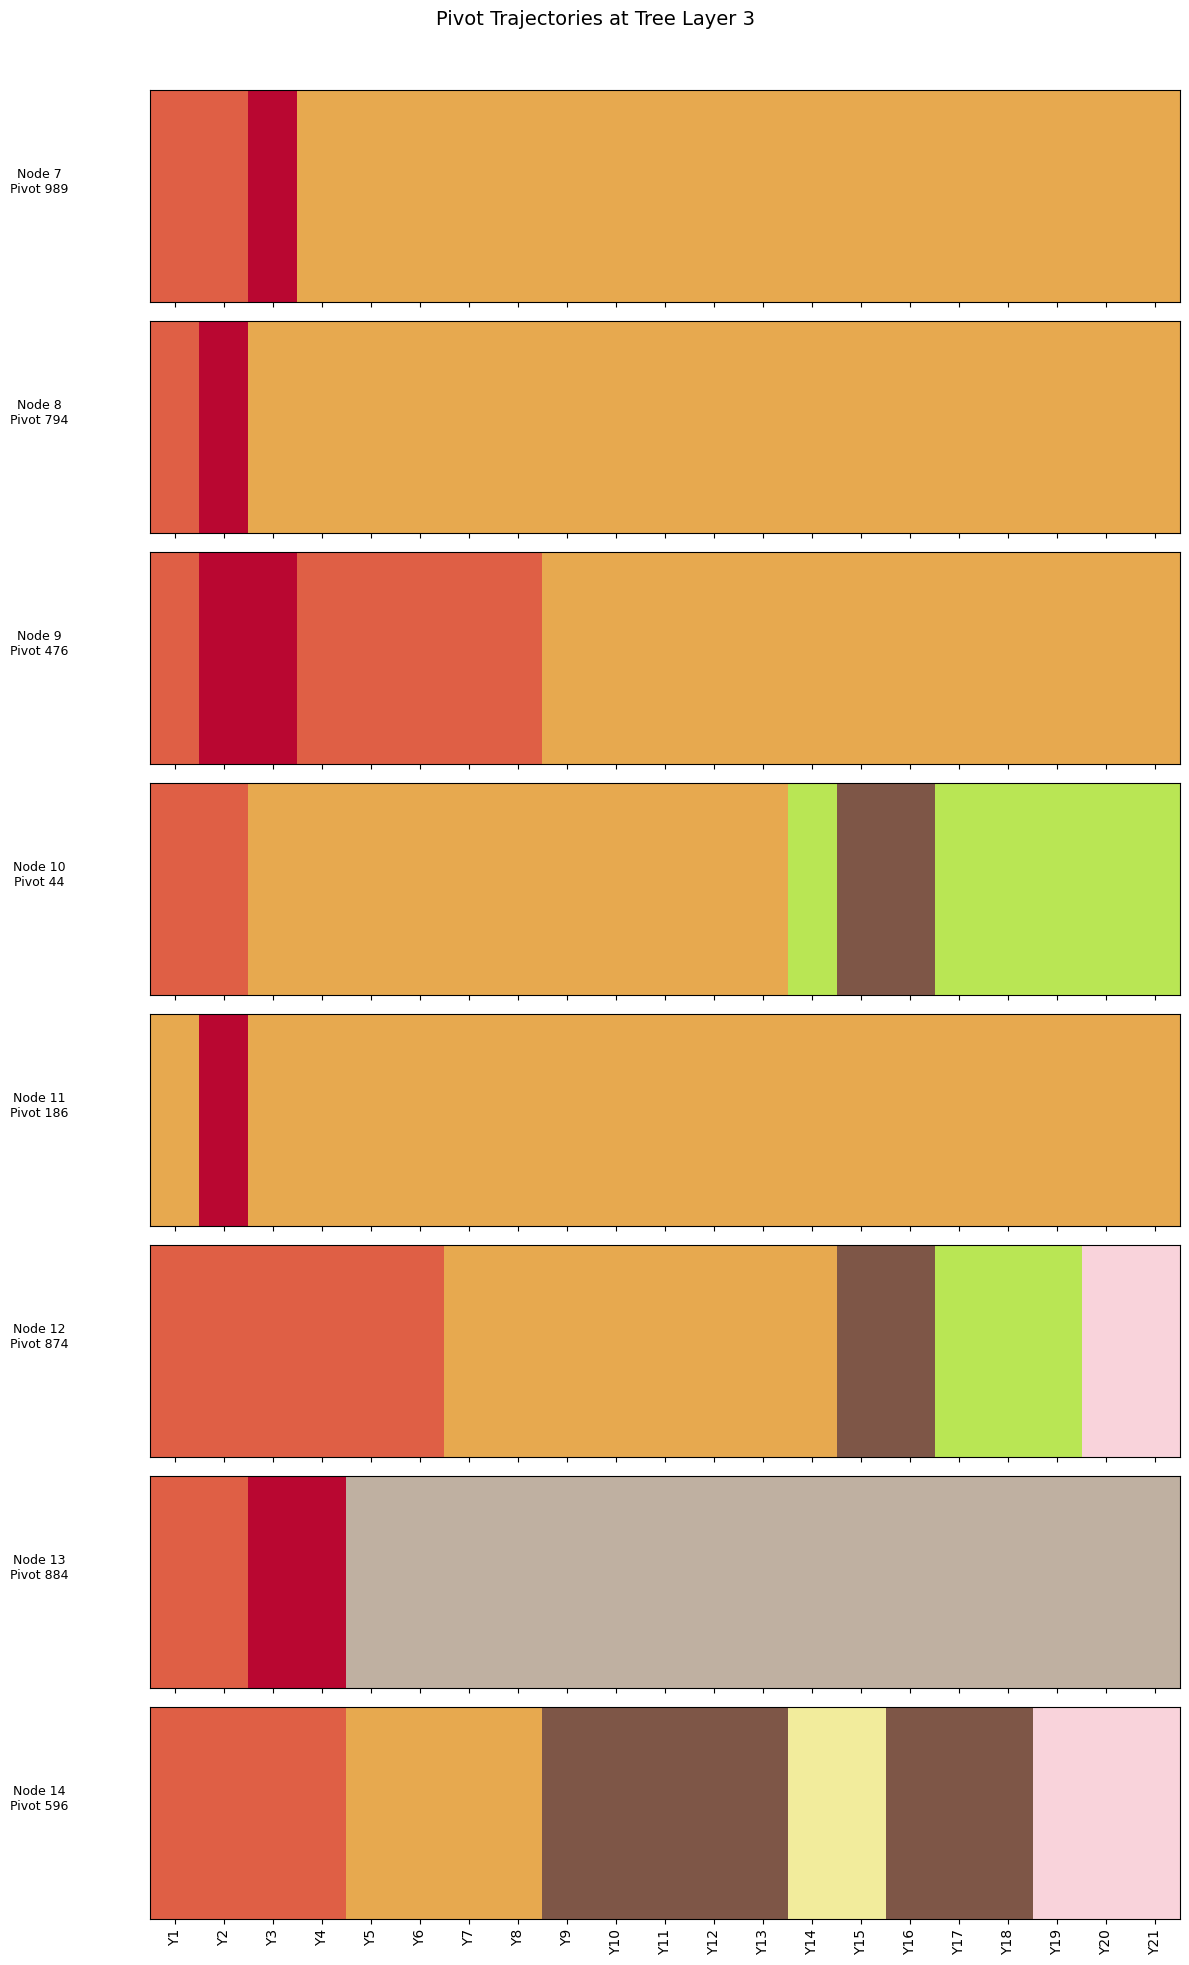

In [30]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# 你的状态名和颜色（确保和训练一致）
states = ['EDU', 'FT', 'MARGINAL', 'MIL/CS', 'PLEAVE', 'PT', 'SELF', 'UNEMP']
state_colors = ['#DF5F45', '#E7A94F', '#F9D3DB', '#B90731', '#7E5647', '#F2EC9C', '#BFB0A1', '#B9E654']
state2id = {s: i for i, s in enumerate(states)}

# 替换为你的真实数据
sequence_df = activity_df # 你上传的原始轨迹数据

# 提取 depth=3 的所有节点
layer3_nodes = [n for n in tree.nodes if n.depth == 3 and n.pivot_idx is not None]

# 画图准备
fig, ax = plt.subplots(len(layer3_nodes), 1, figsize=(12, 2.5 * len(layer3_nodes)), sharex=True)

for i, node in enumerate(layer3_nodes):
    pivot_idx = node.pivot_idx
    if pivot_idx >= len(sequence_df):
        continue
    seq = sequence_df.iloc[pivot_idx][1:].values  # 去掉ID列
    seq_ids = [state2id[s] for s in seq if s in state2id]
    ax[i].imshow([seq_ids], aspect="auto", cmap=ListedColormap(state_colors), vmin=0, vmax=len(states)-1)
    ax[i].set_yticks([])
    ax[i].set_ylabel(f"Node {node.node_id}\nPivot {pivot_idx}", rotation=0, labelpad=80, fontsize=9)
    ax[i].set_xticks(range(len(seq_ids)))
    ax[i].set_xticklabels([f"Y{j+1}" for j in range(len(seq_ids))], rotation=90)

plt.suptitle("Pivot Trajectories at Tree Layer 3", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.94)
plt.show()


In [31]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_state_distributions_by_year(activity_df, node_a_indices, node_b_indices, states):
    """
    对比两个节点中每一年状态的分布差异

    Parameters:
        activity_df: 原始行为轨迹DataFrame（列为ID + 年份状态）
        node_a_indices: 第一个节点的样本索引列表
        node_b_indices: 第二个节点的样本索引列表
        states: 所有可能的状态列表
    """
    years = activity_df.columns[1:]  # 假设第0列是ID
    node_a_data = activity_df.iloc[node_a_indices, 1:]
    node_b_data = activity_df.iloc[node_b_indices, 1:]

    fig, axes = plt.subplots(len(years), 1, figsize=(10, 2.5 * len(years)), sharex=True)
    for i, year in enumerate(years):
        ax = axes[i]
        dist_a = node_a_data[year].value_counts(normalize=True).reindex(states, fill_value=0)
        dist_b = node_b_data[year].value_counts(normalize=True).reindex(states, fill_value=0)

        df_plot = pd.DataFrame({
            'State': states,
            'Node A': dist_a.values,
            'Node B': dist_b.values
        })

        df_plot.set_index('State')[['Node A', 'Node B']].plot(kind='bar', ax=ax, color=['#4C72B0', '#55A868'])
        ax.set_title(f'State Distribution in {year}')
        ax.set_ylabel('Proportion')
        ax.set_xlabel('')
        ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


In [32]:
from scipy.stats import entropy

def compute_entropy_distribution(sequences, states):
    """
    计算每一年上的状态分布熵
    """
    year_cols = sequences.columns[1:]
    entropies = []
    for col in year_cols:
        probs = sequences[col].value_counts(normalize=True).reindex(states, fill_value=0)
        entropies.append(entropy(probs, base=2))
    return entropies

def plot_entropy_gain(parent_indices, left_indices, right_indices, activity_df, states):
    """
    可视化父节点与子节点之间的信息增益
    """
    parent_seqs = activity_df.iloc[parent_indices]
    left_seqs = activity_df.iloc[left_indices]
    right_seqs = activity_df.iloc[right_indices]

    parent_entropy = compute_entropy_distribution(parent_seqs, states)
    left_entropy = compute_entropy_distribution(left_seqs, states)
    right_entropy = compute_entropy_distribution(right_seqs, states)

    avg_child_entropy = [(l + r) / 2 for l, r in zip(left_entropy, right_entropy)]
    info_gain = [p - c for p, c in zip(parent_entropy, avg_child_entropy)]

    years = activity_df.columns[1:]

    plt.figure(figsize=(12, 5))
    plt.plot(years, parent_entropy, label='Parent Entropy', marker='o')
    plt.plot(years, avg_child_entropy, label='Avg Child Entropy', marker='o')
    plt.plot(years, info_gain, label='Information Gain', linestyle='--', marker='s')
    plt.axhline(0, color='gray', linestyle='--')
    plt.legend()
    plt.title("Entropy and Information Gain per Year")
    plt.ylabel("Entropy (bits)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


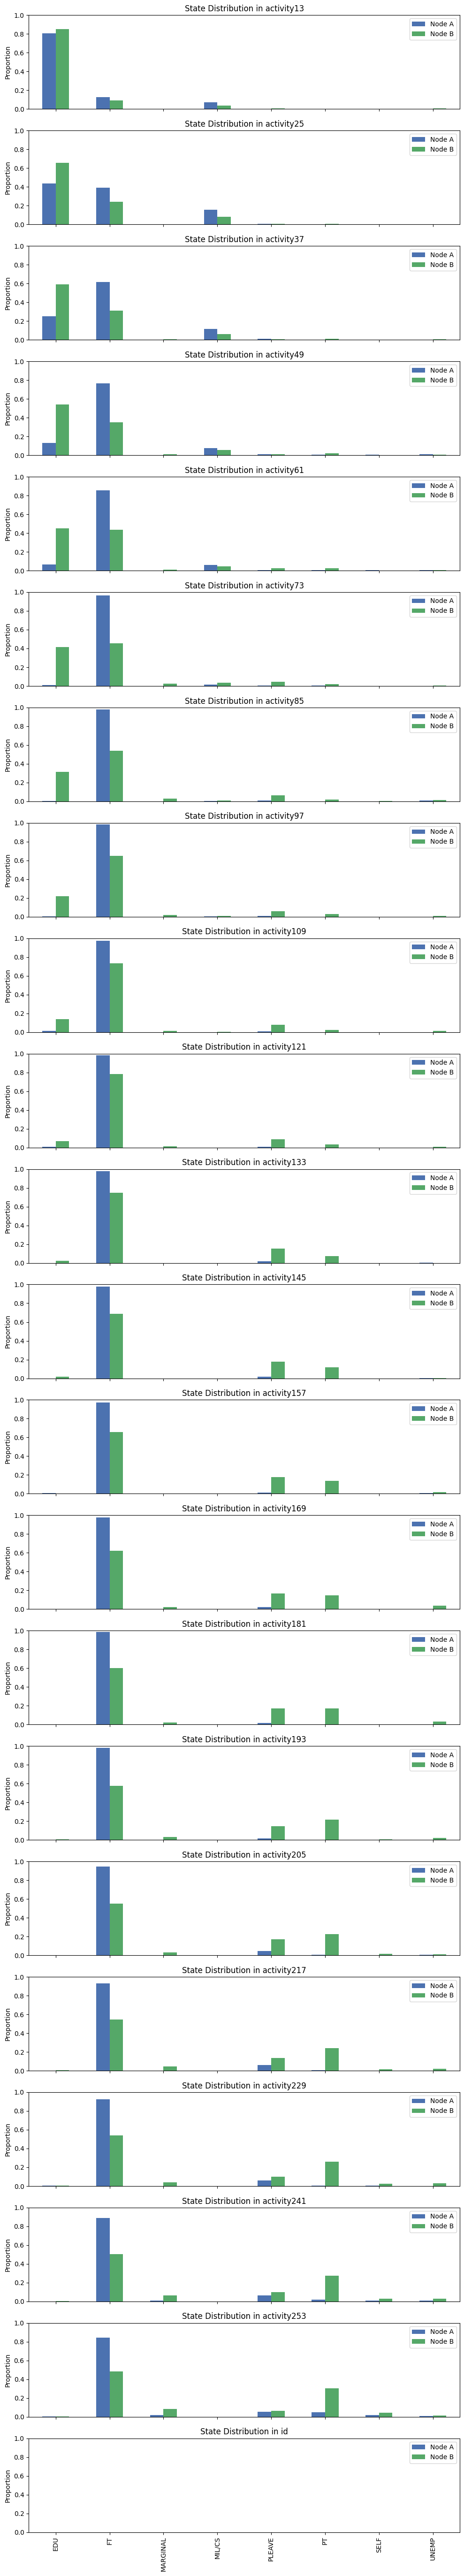

In [35]:
plot_state_distributions_by_year(
    activity_df=activity_df,
    node_a_indices=tree.nodes[3].indices,
    node_b_indices=tree.nodes[4].indices,
    states=states
)


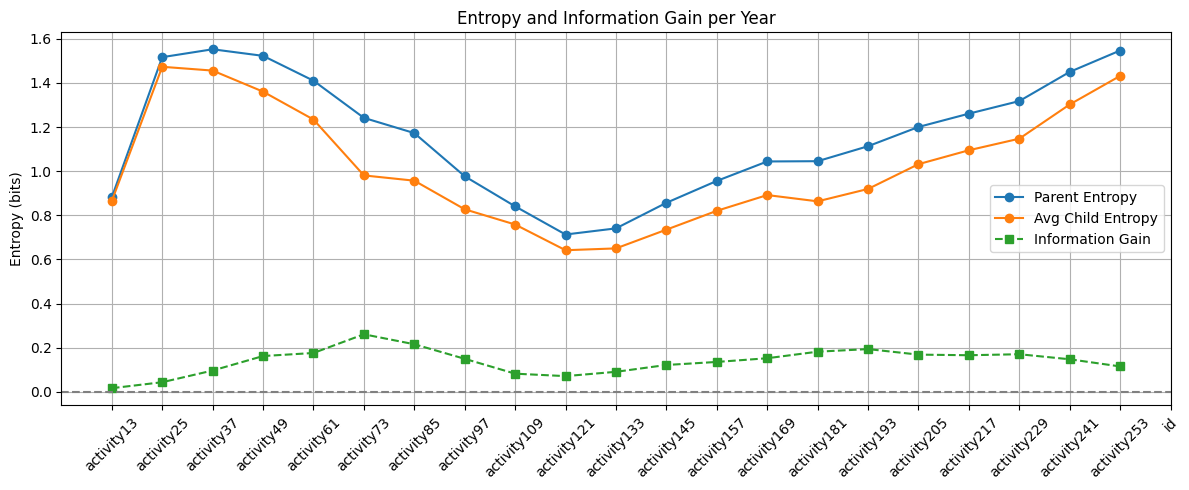

In [37]:
plot_entropy_gain(
    parent_indices=tree.nodes[1].indices,
    left_indices=tree.nodes[3].indices,
    right_indices=tree.nodes[4].indices,
    activity_df=activity_df,
    states=states
)



🧠 方法 A：结构后解释（节点分析）

输出为每个节点协变量的均值或类别比例，可用于：

表格展示

可视化对比（如 heatmap, barplot）

显著性检验（后续可扩展）

In [71]:
import pandas as pd

def analyze_covariates_by_node(tree, seqdata, full_data, covariate_columns, id_column="id"):
    """
    分析每个节点上协变量（covariates）的分布差异。
    
    参数：
        tree: 已经fit好的SoftTreeOM对象
        full_data: 原始DataFrame（包含id和协变量）
        covariate_columns: 你想分析的列名列表，比如 ["sex", "yeduc", "church"]
        id_column: id列名，默认是 "id"
    
    返回：
        一个DataFrame，每行是一个节点，列是各种协变量的统计
    """
    results = []

    for node in tree.nodes:
        indices = [seqdata.ids[i] for i in node.indices]  # 映射为真实 ID 值
        node_data = full_data[full_data[id_column].isin(indices)]
        node_result = {"node_id": node.node_id, "n": len(node_data)}

        for col in covariate_columns:
            if pd.api.types.is_numeric_dtype(full_data[col]):
                # 数值型变量，取均值
                node_result[f"{col}_mean"] = node_data[col].mean()
            else:
                # 类别型变量，取比例
                value_counts = node_data[col].value_counts(normalize=True)
                for cat, prop in value_counts.items():
                    node_result[f"{col}={cat}"] = round(prop, 3)

        results.append(node_result)

    return pd.DataFrame(results)


In [72]:
df_result = analyze_covariates_by_node(
    tree=tree,
    seqdata=activity_sequence,
    full_data=activity_df,  # 包含id和协变量
    covariate_columns=["sex", "yeduc", "church", "ethni", "east", "migstatus"],
    id_column="id"
)

df_result

,node_id,n,sex_mean,yeduc_mean,church_mean,ethni_mean,east_mean,migstatus_mean
0,0,1027,0.507303,13.676728,0.399015,1.181110,0.387537,0.996105
1,1,529,0.457467,12.631380,0.373563,1.145558,0.415879,0.998110
2,2,498,0.560241,14.787149,0.425963,1.218876,0.357430,0.993976
3,3,280,0.539286,12.891071,0.410714,1.203571,0.425000,1.039286
4,4,249,0.365462,12.339357,0.330579,1.080321,0.405622,0.951807
...,...,...,...,...,...,...,...,...
58,58,26,0.307692,16.865385,0.538462,1.076923,0.384615,1.076923
59,59,38,0.447368,16.157895,0.315789,0.868421,0.263158,0.631579
60,60,27,0.333333,15.185185,0.407407,1.444444,0.370370,1.222222
61,61,41,0.414634,14.109756,0.439024,1.512195,0.414634,1.073171


In [73]:
import pandas as pd
import scipy.stats as stats

def chi_square_test_sex_vs_node(tree, seqdata, full_data, sex_column="sex", id_column="id"):
    """
    执行卡方独立性检验：路径节点归属 与 性别 是否有关联。
    
    参数：
        tree: 已训练好的 SoftTreeOM 对象
        seqdata: SequenceData 对象，必须有 .ids 属性（顺序与 tree.indices 一致）
        full_data: 原始 DataFrame（含id和sex）
        sex_column: 性别列名（默认 "sex"）
        id_column: id列名（默认 "id"）
    
    返回：
        一个 dict，包含：
            - "crosstab"：性别 × 节点的频数表
            - "chi2"：卡方值
            - "p_value"：显著性
            - "dof"：自由度
            - "expected"：理论独立假设下的预期频数表
    """
    data = []

    for node in tree.nodes:
        # 把索引映射为真实 ID
        indices = [seqdata.ids[i] for i in node.indices]
        node_data = full_data[full_data[id_column].isin(indices)]

        for _, row in node_data.iterrows():
            data.append({
                "node_id": node.node_id,
                "sex": row[sex_column]
            })

    df = pd.DataFrame(data)

    if df.empty:
        return {"error": "No matched data between tree indices and full_data ids."}

    # 构造交叉表：行是 sex，列是 node_id
    crosstab = pd.crosstab(df["sex"], df["node_id"])

    # 卡方检验
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)

    return {
        "crosstab": crosstab,
        "chi2": chi2,
        "p_value": p,
        "dof": dof,
        "expected": expected
    }


In [75]:
result = chi_square_test_sex_vs_node(
    tree=tree,
    seqdata=activity_sequence,
    full_data=activity_df,
    sex_column="sex",  # 1 = 女性（如果你的数据是这样）
    id_column="id"
)

# 查看结果
print("p-value =", result["p_value"])
result["crosstab"]


p-value = 1.25805254738503e-102


node_id,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
sex,,,,,,,,,,,,,,,,,,,,,
0,506,287,219,129,158,124,95,110,19,108,...,13,1,2,6,5,18,21,18,24,1
1,521,242,279,151,91,127,152,72,79,24,...,13,19,30,24,31,8,17,9,17,16


方法	目的
计算标准化残差（standardized residuals）	看每个节点的性别偏离有多大

In [76]:
import numpy as np
import pandas as pd

def calculate_standardized_residuals(crosstab, expected):
    """
    计算标准化残差 (standardized residuals)，用于判断哪些节点与性别显著偏离独立性。

    参数：
        crosstab: 实际频数表（如 pd.crosstab(sex, node_id)）
        expected: 卡方检验返回的期望频数矩阵 (np.array)

    返回：
        residuals_df: 标准化残差表（DataFrame）
            > 2 表示该格子观察频数显著高于期望（over-represented）
            < -2 表示观察频数显著低于期望（under-represented）
    """
    # 实际观测频数
    observed = crosstab.values

    # 标准化残差公式
    residuals = (observed - expected) / np.sqrt(expected)

    # 转回 DataFrame，保持原行列标签
    residuals_df = pd.DataFrame(
        residuals,
        index=crosstab.index,
        columns=crosstab.columns
    )

    return residuals_df


In [77]:

# 计算标准化残差
residuals_df = calculate_standardized_residuals(result["crosstab"], result["expected"])

# 查看女性在节点上的残差（通常 sex=1 表示女性）
female_residuals = residuals_df.loc[1].sort_values(ascending=False)
print(female_residuals.head(10))  # 查看女性最超代表的节点


node_id
8     4.153254
27    4.020348
13    3.794390
43    3.746093
18    3.638793
55    3.416716
57    2.980476
54    2.779637
37    2.599051
38    2.557222
Name: 1, dtype: float64


方法 B：协变量预测结构（监督模型）

In [64]:
import scipy.stats as stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

def supervised_prediction_of_node_membership(tree, full_data, covariate_columns, id_column="id"):
    """
    用协变量预测个体属于哪个Soft Tree节点（多分类logistic回归）。
    
    参数：
        tree: 已经fit好的SoftTreeOM对象
        full_data: 原始DataFrame（包含id和协变量）
        covariate_columns: 特征列，比如 ["sex", "yeduc", "church"]
        id_column: id列名，默认是 "id"
    
    返回：
        report_df: 分类效果评估表（准确率、F1等）
        model: 训练好的LogisticRegression对象
        feature_names: 特征名称列表
    """
    # 构造个体到节点的映射
    labels = []
    id_to_node = {}
    for node in tree.nodes:
        for idx in node.indices:
            id_to_node[idx] = node.node_id

    full_data = full_data.copy()
    full_data["node_label"] = full_data[id_column].map(id_to_node)

    # 过滤掉没有归属标签的样本
    labeled_data = full_data.dropna(subset=["node_label"])
    X = labeled_data[covariate_columns]
    y = labeled_data["node_label"]

    # 类别变量独热编码
    X_encoded = pd.get_dummies(X)

    # 训练多类别logistic回归
    model = LogisticRegression(max_iter=1000, multi_class='multinomial')
    model.fit(X_encoded, y)
    y_pred = model.predict(X_encoded)

    # 分类效果报告
    report = classification_report(y, y_pred, output_dict=True)
    return pd.DataFrame(report).T, model, X_encoded.columns


In [65]:
report_df, model, feature_names = supervised_prediction_of_node_membership(
    tree=tree,
    full_data=activity_df,
    covariate_columns=["sex", "yeduc", "church", "ethni", "east", "migstatus"],
    id_column="id"
)


ValueError: Found array with 0 sample(s) (shape=(0, 6)) while a minimum of 1 is required by LogisticRegression.